In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import imutils
from imutils import face_utils
import dlib
import webcolors

#Function to visualize RGB Mean Color:

In [2]:
def plot_color(rgb_value):

  # normalize RBG value
  rgb_value_norm = tuple(channel / 255.0 for channel in rgb_value)

  # set up figure
  fig, ax = plt.subplots(figsize=(2,2))
  ax.axis('off')

  # plot the color
  ax.add_patch(plt.Rectangle((0, 0), 2, 2, color=rgb_value_norm))

  plt.show()

#Version 1 (Erosion):

There is some trouble with blonde hair
Only looks at a very tiny region

In [3]:
## Working Version 1: erosion
# trouble with blonde hair
def get_rgb_mean_color_erosion(img_name):
  
  img = cv2.imread(img_name)
  cv2_imshow(img)

  # convert image to grayscale
  grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # use bilateral filter to reduce noise in the image
  filtered_img = cv2.bilateralFilter(grayscale_img, 9, 75, 75)

  # use adaptive thresholding on  hair region
  # ADAPTIVE_THRESH_MEAN_C: the threshold value is the mean of the neighbourhood area minus the constant C. 
  threshold = cv2.adaptiveThreshold(filtered_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 4)

  # use erosion on hair region
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
  erosion = cv2.erode(threshold, kernel, iterations=3)

  # get the largest connected component, which is likely to be the person's hair
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(erosion)
  largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

  # get the mean color of the pixels in the largest connected component
  mask = np.uint8(labels == largest_label)
  mean_color = cv2.mean(img, mask=mask)

  # apply mask to the original image
  hair_region = cv2.bitwise_and(img, img, mask=mask)

  # show hair region
  cv2_imshow(hair_region)

  # convert to RGB
  rgb_mean_color = mean_color[::-1][1:]
  print('')
  print("Hair color (RGB): ", rgb_mean_color)

  # visualize the mean color of the hair
  plot_color(rgb_mean_color)

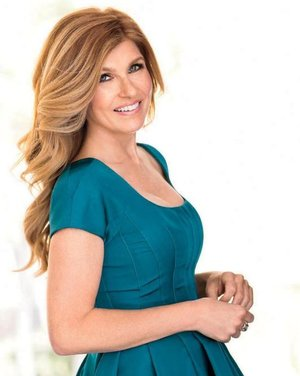

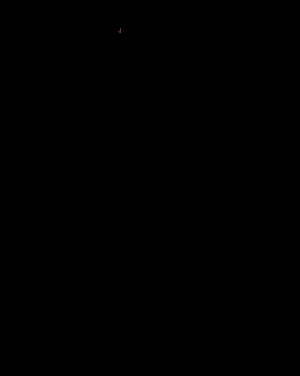


Hair color (RGB):  (87.625, 52.0, 39.375)


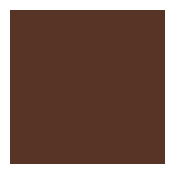

In [4]:
img_name = 'connie-britton.jpeg'
get_rgb_mean_color_erosion(img_name)

#Version 2 (Opening)

Try doing erosion --> dilation (opening)

Seems like: will find the darkest part of someone's hair

In [5]:
## Working Version 2: Opening
def get_rgb_mean_color_opening(img_name):

  img = cv2.imread(img_name)
  cv2_imshow(img)

  # convert image to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # use bilateral filter to reduce noise in the image
  filtered = cv2.bilateralFilter(gray, 9, 75, 75)

  # use adaptive thresholding on  hair region
  # ADAPTIVE_THRESH_MEAN_C: the threshold value is the mean of the neighbourhood area minus the constant C. 
  thresh = cv2.adaptiveThreshold(filtered, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 4)

  # use opening on hair region
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
  opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=3)

  # get the largest connected component, which is likely to be the person's hair
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(opening)
  largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

  # get the mean color of the pixels in the largest connected component
  mask = np.uint8(labels == largest_label)
  mean_color = cv2.mean(img, mask=mask)

  # show hair region
  hair_region = cv2.bitwise_and(img, img, mask=mask)
  cv2_imshow(hair_region)

  # convert to RGB
  rgb_mean_color = mean_color[::-1][1:]

  print('')
  print("Hair color (RGB): ", rgb_mean_color)

  # visualize the mean color of the hair
  plot_color(rgb_mean_color)

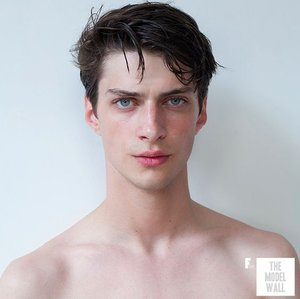

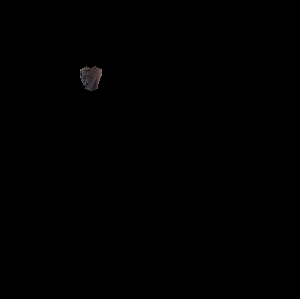


Hair color (RGB):  (65.02153110047847, 56.5645933014354, 57.98803827751196)


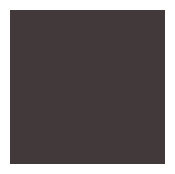

In [6]:
img_name = 'matthew-bell.jpeg'
get_rgb_mean_color_opening(img_name)

#Version 3: Opening (with Changes)

if we want to tweak this code:
- change neighborhood size or constant size in adaptiveThreshold
- channge size of kernal
- change number of iterations in opened

In [56]:
## Working Version 3: Opening (with edits)
def get_rgb_mean_color_opening_v3(img_name):

  image = cv2.imread(img_name)
  #cv2_imshow(image)

  # convert image to grayscale
  grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # use bilateral filter to reduce noise in the image
  filtered_image = cv2.bilateralFilter(grayscale, 9, 75, 75)

  # use adaptive thresholding on  hair region: hair is white, background is black
  # ADAPTIVE_THRESH_MEAN_C: the threshold value is the mean of the neighbourhood area minus the constant C. 
  threshold = cv2.adaptiveThreshold(filtered_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 9)

  # get 5x5 elliptical structuring element
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
  
  # use morphological opening (erosion --> dilation) on hair region using kernel
  opening = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, kernel, iterations=3)

  # gets connected components (all white pixels) of the binary image
  retvals, labels, stats, centroids = cv2.connectedComponentsWithStats(opening)

  # get the index of the largest connected component (person's hair)
  hair_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

  # get the mean color of the hair
  hair_mask = np.uint8(labels == hair_label)
  hair_mean_color = cv2.mean(image, mask=hair_mask)

  # show hair region
  hair_region = cv2.bitwise_and(image, image, mask=hair_mask)
  #cv2_imshow(hair_region)

  # convert mean hair color to RGB
  rgb_hair_mean_color = hair_mean_color[::-1][1:]

  print('')
  print("Hair color (RGB): ", rgb_hair_mean_color)

  # visualize the mean hair color
  plot_color(rgb_hair_mean_color)
  return rgb_hair_mean_color

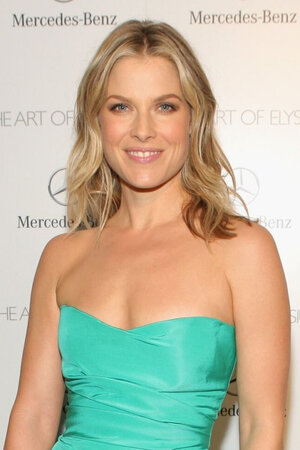

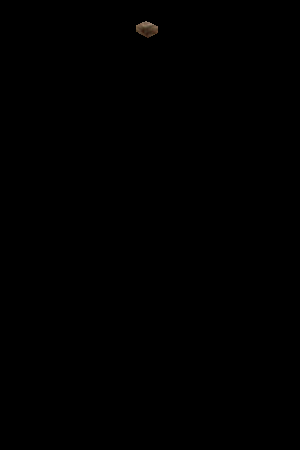


Hair color (RGB):  (92.37307692307692, 71.63846153846154, 53.43846153846154)


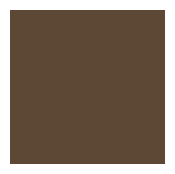

In [41]:
img_name = 'ali-larter.jpeg'
rgb_hair_mean_color = get_rgb_mean_color_opening_v3(img_name)

# Skin Color Detection

https://medium.datadriveninvestor.com/skin-segmentation-and-dominant-tone-color-extraction-fe158d24badf

In [9]:
def extractSkin(image_path):
    # Taking a copy of the image
    image = cv2.imread(image_path)
    img = image.copy()
    # Converting from BGR Colours Space to HSV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Defining HSV Threadholds
    lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
    upper_threshold = np.array([20, 255, 255], dtype=np.uint8)

    # Single Channel mask,denoting presence of colours in the about threshold
    skinMask = cv2.inRange(img, lower_threshold, upper_threshold)

    # Cleaning up mask using Gaussian Filter
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)

    # Extracting skin from the threshold mask
    skin = cv2.bitwise_and(img, img, mask=skinMask)
    skin_color = cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)

    # Determine the skin undertone based on the skin color
    #skin_undertone = detect_skin_undertone(skin_color)

    # Return the Skin and skin_undertone
    return skin_color #, skin_undertone

In [10]:
def removeBlack(estimator_labels, estimator_cluster):

    # Check for black
    hasBlack = False

    # Get the total number of occurance for each color
    occurance_counter = Counter(estimator_labels)

    # Quick lambda function to compare to lists
    def compare(x, y): return Counter(x) == Counter(y)

    # Loop through the most common occuring color
    for x in occurance_counter.most_common(len(estimator_cluster)):

        # Quick List comprehension to convert each of RBG Numbers to int
        color = [int(i) for i in estimator_cluster[x[0]].tolist()]

        # Check if the color is [0,0,0] that if it is black
        if compare(color, [0, 0, 0]) == True:
            # delete the occurance
            del occurance_counter[x[0]]
            # remove the cluster
            hasBlack = True
            estimator_cluster = np.delete(estimator_cluster, x[0], 0)
            break

    return (occurance_counter, estimator_cluster, hasBlack)

In [11]:
def getColorInformation(estimator_labels, estimator_cluster, hasThresholding=True):

    # Variable to keep count of the occurance of each color predicted
    occurance_counter = None

    # Output list variable to return
    colorInformation = []

    # Check for Black
    hasBlack = False

    # If a mask has be applied, remove th black
    if hasThresholding == True:

        (occurance, cluster, black) = removeBlack(
            estimator_labels, estimator_cluster)
        occurance_counter = occurance
        estimator_cluster = cluster
        hasBlack = black

    else:
        occurance_counter = Counter(estimator_labels)

    # Get the total sum of all the predicted occurances
    totalOccurance = sum(occurance_counter.values())

    # Loop through all the predicted colors
    for x in occurance_counter.most_common(len(estimator_cluster)):

        index = (int(x[0]))

        # Quick fix for index out of bound when there is no threshold
        index = (index-1) if ((hasThresholding & hasBlack)
                              & (int(index) != 0)) else index

        # Get the color number into a list
        color = estimator_cluster[index].tolist()

        # Get the percentage of each color
        color_percentage = (x[1]/totalOccurance)

        # make the dictionay of the information
        colorInfo = {"cluster_index": index, "color": color,
                     "color_percentage": color_percentage}

        # Add the dictionary to the list
        colorInformation.append(colorInfo)

    return colorInformation

In [12]:
def extractDominantColor(image, number_of_colors=1, hasThresholding=False):

    # Quick Fix Increase cluster counter to neglect the black
    if hasThresholding == True:
        number_of_colors += 1

    # Taking Copy of the image
    img = image.copy()

    # Convert Image into RGB Colours Space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Reshape Image
    img = img.reshape((img.shape[0]*img.shape[1]), 3)

    # Initiate KMeans Object
    estimator = KMeans(n_clusters=number_of_colors, random_state=0)

    # Fit the image
    estimator.fit(img)

    # Get Colour Information
    colorInformation = getColorInformation(
        estimator.labels_, estimator.cluster_centers_, hasThresholding)
    return colorInformation

In [13]:
def plotColorBar(colorInformation):
    # Create a 500x100 black image
    color_bar = np.zeros((100, 500, 3), dtype="uint8")

    top_x = 0
    for x in colorInformation:
        bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

        color = tuple(map(int, (x['color'])))

        cv2.rectangle(color_bar, (int(top_x), 0),
                      (int(bottom_x), color_bar.shape[0]), color, -1)
        top_x = bottom_x
    return color_bar

#Skin Undertone guidelines:

Some general ranges of RGB values for cool and warm skin tones could be:

Cool skin tones:

Red channel: 150-190
Green channel: 100-150
Blue channel: 170-210

Warm skin tones:

Red channel: 190-230
Green channel: 150-200
Blue channel: 100-150

In [14]:
#@title Skin Undertone Detection
def detect_skin_undertone(skin_color):
    # Convert the skin color from BGR to RGB format
    r, g, b = skin_color
    rgb_skin_color = np.array([r, g, b])
    print("Skin Color (RGB):", rgb_skin_color)
    # 217.58925027340172, 127.78310178619252, 106.00816152947283 -- warm
    # 204.70284037654937, 164.9076979502392, 143.86079302337546 -- cool
    # 225.32433909619718, 176.3202830595688, 149.9362540632074 -- cool

    # Determine the skin undertone based on the RGB values of the skin color
    if np.all(rgb_skin_color >= np.array([190, 120, 100])) and np.all(rgb_skin_color <= np.array([255, 255, 140])):
        return 'Warm'
    else:
        return 'Cool'

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Color Information


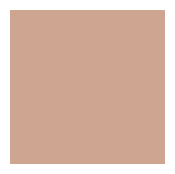

Skin Color (RGB): [204.70284038 164.90769795 143.86079302]
Cool


In [50]:
image = 'alexandra-daddario.jpeg'
img = cv2.imread(image)
#cv2_imshow(img)
# Apply Skin Mask
skin = extractSkin(image)

# Find the dominant color. Default is 1 , pass the parameter 'number_of_colors=N' where N is the specified number of colors
dominantColors = extractDominantColor(skin, hasThresholding=True)

# Show in the dominant color information
print("Color Information")
index = 0
for item in dominantColors:
  if (sum(item['color']) / len(item['color'])) < 10:
     dominantColors.pop(index)
  index += 1
# Plot the dominant skin color
rgb_skin = dominantColors[0]['color']
#print(rgb_skin)
plot_color(rgb_skin)
# Detect skin undertone
print(detect_skin_undertone(rgb_skin))

# Eye Color Detection

In [51]:
def find_eye_color(img_path):
  flag=0
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

  img= cv2.imread(img_path)
  img_rgb= cv2.cvtColor(img,cv2.COLOR_BGR2RGB)   #convert to RGB
  #cap = cv2.VideoCapture(0)
  (left_Start, left_End) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]            
  #points for left eye and right eye
  (right_Start, right_End) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
  gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
  # detect dlib face rectangles in the grayscale frame
  dlib_faces = detector(gray, 0)
  
  for face in dlib_faces:
      # store 2 eyes
      eyes = []                          
      # convert dlib rect to a bounding box
      (x,y,w,h) = face_utils.rect_to_bb(face)
      #draws blue box over face 
      cv2.rectangle(img_rgb,(x,y),(x+w,y+h),(255,0,0),1)      
      shape = predictor(gray, face)
      shape = face_utils.shape_to_np(shape)
      leftEye = shape[left_Start:left_End]               
      rightEye = shape[right_Start:right_End]
      eyes.append(leftEye)  # wrap in a list
      eyes.append(rightEye)
      
      for index, eye in enumerate(eyes):
          flag+=1
          left_side_eye = eye[0]  # left edge of eye
          right_side_eye = eye[3]  # right edge of eye
          top_side_eye = eye[1]  # top side of eye
          bottom_side_eye = eye[4]  # bottom side of eye

          # calculate height and width of dlib eye keypoints
          eye_width = right_side_eye[0] - left_side_eye[0]
          eye_height = bottom_side_eye[1] - top_side_eye[1]

          # create bounding box with buffer around keypoints
          eye_x1 = int(left_side_eye[0] - 0 * eye_width)  
          eye_x2 = int(right_side_eye[0] + 0 * eye_width)  

          eye_y1 = int(top_side_eye[1] - 1 * eye_height)
          eye_y2 = int(bottom_side_eye[1] + 0.75 * eye_height)

          # draw bounding box around eye roi
          #cv2.rectangle(img_rgb,(eye_x1, eye_y1), (eye_x2, eye_y2),(0,255,0),2) 
          
          roi_eye = img_rgb[eye_y1:eye_y2 ,eye_x1:eye_x2]     #  desired EYE Region(RGB)
          if flag==1:
              break
          
      x=roi_eye.shape                                                        
      row=x[0] 
      col=x[1]                           
      # pick RGB values from the area just below pupil
      # NEED TO PLAY AROUND WITH THIS CALCULATION BC WHERE IS IRIS IN RELATION TO PUPIL??
      array1=roi_eye[row//2:(row//2)+1,int((col//3)+3):int((col//3))+6]         
      array1=array1[0][2]
      array1=tuple(array1)   #store it in tuple and pass this tuple to "find_color" Funtion
      #cv2_imshow(img)
      cv2_imshow(roi_eye)
      plot_color(array1)
      return roi_eye, array1                                              

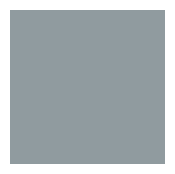

In [52]:
roi_eye, eye_color = find_eye_color('zooey-deschanel.jpeg')

# Contrast detection

In [53]:
def relative_luminance(color):
    r, g, b = color
    return 0.2126 * r + 0.7152 * g + 0.0722 * b

# l1 should be the lighter color and l2 should be the darker color!!!
def color_contrast(color1, color2):
    l1 = relative_luminance(color1)
    l2 = relative_luminance(color2)
    return (l1 + 0.05) / (l2 + 0.05)

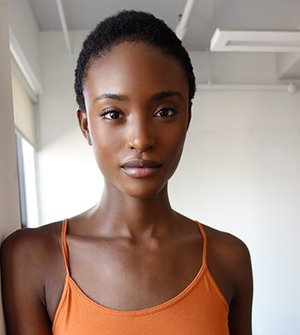

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Skin color:


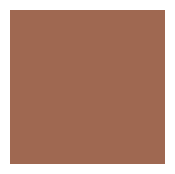

Hair color:

Hair color (RGB):  (38.425714285714285, 34.08857142857143, 37.68857142857143)


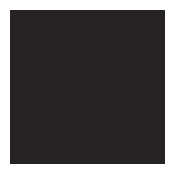

Eye color:


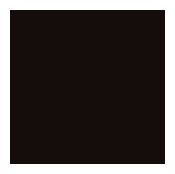

Skin-Hair Contrast: 3.231118645933856
Skin-Eye Contrast: 7.8133520819486435
Hair-Eye Contrast: 2.4181569722861207
Average Contrast: 4.487542566722873


In [58]:
# RGB values for skin, hair, and eye color
image_name = 'alicia-burke.jpeg'
img = cv2.imread(image_name)
cv2_imshow(img)

# skin color
skin = extractSkin(image_name)
dominantColors = extractDominantColor(skin, hasThresholding=True)
index = 0
for item in dominantColors:
  if (sum(item['color']) / len(item['color'])) < 10:
     dominantColors.pop(index)
  index += 1
rgb_skin = dominantColors[0]['color']
print("Skin color:")
plot_color(rgb_skin)

print("Hair color:")
rgb_hair = get_rgb_mean_color_opening_v3(image_name)

print("Eye color:")
roi_eye, rgb_eye = find_eye_color(image_name)

# Calculate the contrast between skin and hair color
skin_hair_contrast = color_contrast(rgb_skin, rgb_hair)
print("Skin-Hair Contrast:", skin_hair_contrast)

# Calculate the contrast between skin and eye color
skin_eye_contrast = color_contrast(rgb_skin, rgb_eye)
print("Skin-Eye Contrast:", skin_eye_contrast)

# Calculate the contrast between hair and eye color
hair_eye_contrast = color_contrast(rgb_hair, rgb_eye)
print("Hair-Eye Contrast:", hair_eye_contrast)

# Calculate the average contrast between all three colors
average_contrast = (skin_hair_contrast + skin_eye_contrast + hair_eye_contrast) / 3
print("Average Contrast:", average_contrast)

# Color Season Calculation

# Test on our self taken images